## Week 3: Histopathalogic Cancer Detection

The aim of this project is to detect metastatic cancer in images taken from pathology scans. The data used for this project is a modified verison of the PCam dataset which is both clinically relevent and straight forward problem to appraoch as it is a binary classfiication problem. The dataset consists of nearly 300,000 images each of which is (96, 96, 3) in dimensions.

We will use Convolutional Neural Networks (CNN) to process the patholgy scans and classify whether or not an image contains metastic cancer. The appeal of a cancer detection model like this is readily apparant as it could supplement primary care physicians or even give early results by leveraging a model that is effective in detecting metastatic cancer.

### Table of Contents

1. [Abstract](#abstract)
2. [Data](#data)
    - 2.1 [Load Data](#load)
    - 2.2 [Exploratory Data Analysis (EDA)](#EDA)
3. [Exploratory Data Analysis](#eda)
    - 3.1 [Dense Network](#Dense)
    - 3.2 [CNN Model (Max Pooling)](#CNNM)
    - 3.3 [CNN Model (Average pooling)](#CNNA)
    - 3.4 [CNN (Dropout Layers)](#CNND)
    - 3.5 [CNN (Regularization)](#CNNR)
    - 3.6 [CNN (Nadam Optimizer)](#CNNN)
4. [Conclusion](#conclusion)
5. [Reference](#Ref)

## 1. Abstract

The goal of this project is to develop an algorithm capable of detecting metastatic cancer from small image patches extracted from larger whole-slide pathology scans. The dataset used in this competition is a slightly modified version of the PatchCamelyon (PCam) dataset, which provides a benchmark for binary classification in the context of cancer detection. Unlike the original PCam dataset, which includes duplicate images due to probabilistic sampling, the Kaggle version has been adjusted to exclude these duplicates.

PatchCamelyon consists of 327,680 color images (96x96 pixels) extracted from lymph node tissue pathology scans, each labeled with a binary tag indicating the presence or absence of metastatic tissue. The dataset is designed to be clinically relevant while offering a straightforward binary classification problem, making it an ideal starting point for machine learning models focused on cancer detection.

We will employ Convolutional Neural Networks (CNNs) to classify these small image patches and determine the presence of metastatic cancer. The PCam dataset is particularly appealing due to its manageable size, ease of use, and the balance it strikes between task difficulty and tractability, which makes it a suitable benchmark for research in active learning, model uncertainty, and interpretability. This project will demonstrate how CNNs can be applied to clinical image data, providing insights into early detection and assisting healthcare professionals in diagnosing metastatic cancer.

## 2. Data

## 2.1 Load Data

In [23]:
import os
import keras
import tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
# from google.colab import drive

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

In [4]:
#Loading the train and test datasets.
train_dir = "train"
test_dir = "test"

In [6]:
train_images = []
for image in os.listdir(train_dir):
    image_path = train_dir+"/"+image

    temp_image = Image.open(image_path)
    temp_image_array = np.array(temp_image)
    temp_image.close()

    train_images.append(temp_image_array)

test_images = []
for image in os.listdir(test_dir):
    image_path = test_dir+"/"+image

    temp_image = Image.open(image_path)
    temp_image_array = np.array(temp_image)
    temp_image.close()

    test_images.append(temp_image)
print("Images in train data:",len(train_images))
print("Images in test data:", len(test_images))

Images in train data: 220025
Images in test data: 57458


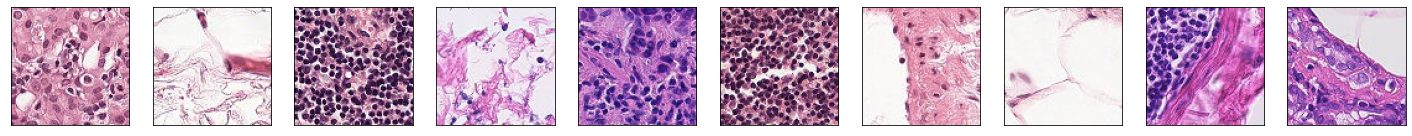

In [7]:
#Dataset Example
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open("./train/"+os.listdir(train_dir)[i])
    plt.imshow(im)

Loading in the labels for the train dataset and inspecting the format of an example submission for the Kaggle challenge.

In [10]:
#Add a column to train_labels with the image paths and convert the label field to a string for use with the image data generator later.
train_labels = pd.read_csv("./train_labels.csv")
sample = pd.read_csv("./sample_submission.csv")
train_labels['path'] = "./train/"+train_labels['id']+".tif"
train_labels['label'] = train_labels['label'].astype(str)
#The labels for the ten example images above.
for i in range(10):
    print(train_labels[train_labels['id']+".tif" == os.listdir(train_dir)[i]]['label'])

151577    1
Name: label, dtype: object
16166    0
Name: label, dtype: object
87832    0
Name: label, dtype: object
69359    0
Name: label, dtype: object
128953    1
Name: label, dtype: object
95060    0
Name: label, dtype: object
134354    0
Name: label, dtype: object
52564    0
Name: label, dtype: object
78234    0
Name: label, dtype: object
90027    1
Name: label, dtype: object


### 2.2 Exploratory Data Analysis (EDA)

In [11]:
#Exploring the distribution of labels in the training dataset.
train_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

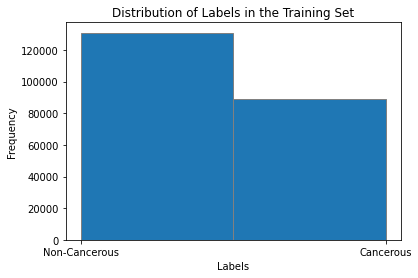

In [12]:
plt.hist(train_labels['label'], bins=2, edgecolor='grey')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Training Set')
plt.show()

Although there is an imbalance in the dataset, with about 60% of the images being non-cancerous and 40% being cancerous, the imbalance is not significant enough to require rebalancing at this stage. Typically, when class imbalance is severe, it can lead to the model being biased toward predicting the majority class, which can negatively impact overall accuracy and the model’s ability to generalize. However, after initial analysis, we believe the current level of imbalance does not significantly affect model performance, so we will not apply class rebalancing at this point. If, during subsequent modeling, we find that the imbalance negatively impacts the model’s performance, or if the model performs poorly on one class, we will consider implementing techniques such as oversampling, undersampling, or other strategies to balance the classes.

In addition to addressing class imbalance, we will also explore other factors that might influence the classification task. While class imbalance is a potential issue, it does not mean there are not other factors in the data that could complicate the task. We have already reviewed some sample images from the training set, and now we will further analyze whether there are noticeable, visually detectable differences between the cancerous and non-cancerous images. For example, there might be differences in color tone, texture, or structure that can help distinguish between the two classes. These features could aid the model in learning finer distinctions during training.

This analysis will provide valuable insights for subsequent model design, data preprocessing, and feature engineering. It may also influence the choice of algorithms and training strategies in the future.

Cancerous Images (Top Row) v. Non-Cancerous Images (Bottom Row)


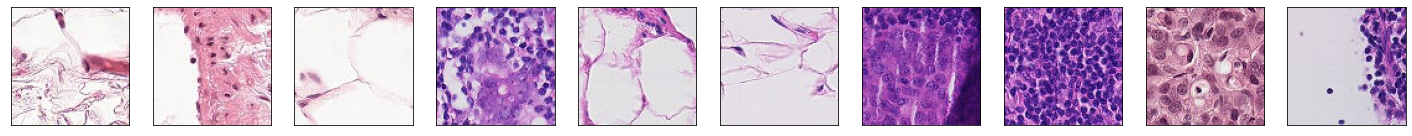

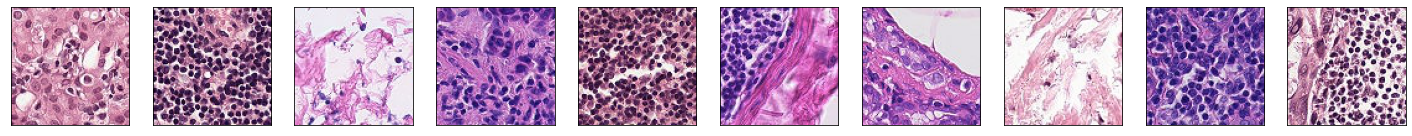

In [14]:
train_labels_viz = train_labels.copy()
train_labels_viz['label'] = train_labels_viz['label'].astype(int)
print("Cancerous Images (Top Row) v. Non-Cancerous Images (Bottom Row)")
fig = plt.figure(figsize=(25, 4))
i = 0
count = 0
non_names = []
while count < 10:
    if train_labels_viz.iloc[i, 1] == 1:
        ax = fig.add_subplot(1, 10, count + 1, xticks=[], yticks=[])
        im = Image.open("./train/"+os.listdir(train_dir)[i])
        plt.imshow(im)
        count += 1
    i += 1


fig = plt.figure(figsize=(25, 4))
i = 0
count = 0
names = []
while count < 10:
    if train_labels_viz.iloc[i, 1] == 0:
        ax = fig.add_subplot(1, 10, count + 1, xticks=[], yticks=[])
        im = Image.open("./train/"+os.listdir(train_dir)[i])
        plt.imshow(im)
        count += 1
    i += 1

Upon a preliminary visual inspection, there are no obvious differences between the cancerous and non-cancerous images. Both exhibit similar colors from the staining process and contain features such as large hollow white cells and small purple cells. The structure of the tissue is complex, and there is considerable variety in the appearance of images across the dataset, which increases the difficulty of distinguishing between the two classes. For the average person, identifying the subtle differences is nearly impossible, which is precisely why we need advanced machine learning models to assist with this task.

Given the complexity of the image data and the subtle structural differences between the images, traditional manual feature extraction methods are not feasible. These methods often struggle to capture the fine-grained distinctions in the images and are inefficient when dealing with high-dimensional data. Therefore, we turn to modern techniques in deep learning and computer vision to solve this problem. By using advanced models like Convolutional Neural Networks (CNNs), we can automatically extract meaningful features from the images that help differentiate between cancerous and non-cancerous tissue.

The advantage of these deep learning models lies in their powerful ability to adapt and learn from large amounts of data. CNNs, in particular, can gradually extract features at various levels of abstraction through multiple convolutional layers, capturing subtle differences between cancerous and non-cancerous images. Unlike human visual inspection, which is limited in its ability to detect such minute differences, machine learning models can efficiently identify patterns in large datasets and generate classification decisions automatically.

Our goal is to leverage these deep learning models to more accurately classify pathology images, identifying the key structural differences between cancerous and non-cancerous images. By doing so, we aim to improve classification accuracy and provide valuable technological support for medical diagnosis, enabling clinicians to detect metastatic cancer earlier and more effectively. This approach not only enhances the precision of medical image classification but also lays the foundation for future applications in medical image analysis.

## 3. Model

In this section, we will accomplish our task by building a Convolutional Neural Network (CNN).

In [15]:
# Split the training dataset (train_images and train_labels) into a training set (X_train, y_train) and a validation set (X_val, y_val) with a 70%/30% split.
# The stratify parameter ensures that the class distribution in the training and validation sets is consistent with the original dataset, maintaining class balance.
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.3, stratify=train_labels.iloc[:, 1])

Now, we have a reduced training set containing 70% of the original training images and a validation set containing 30% of the original training images. To ensure consistency in class distribution between the training and validation data, we used stratified splitting. This method ensures that the class distribution in both the training and validation sets is the same as in the original dataset, thus avoiding class imbalance. Class balance is crucial for machine learning model training, especially when dealing with datasets that have imbalanced class distributions, as it helps prevent the model from being biased towards a particular class.

The purpose of stratified splitting is to ensure that both the training and validation sets are exposed to a representative sample of each class, enabling the model to learn from a balanced range of data. This helps improve the model's generalization ability, prevents overfitting to one class, and enhances the model’s ability to recognize minority classes.

In the following section, we will further verify that the class distribution in both the training and validation sets remains consistent and that no class bias has been introduced during the splitting process. This verification step is crucial for ensuring the accuracy of the data preparation process.

In [16]:
print('Training Class Balance')
print(y_train['label'].value_counts(normalize=True))
print('\nValidation Class Balance')
print(y_val['label'].value_counts(normalize=True))

Training Class Balance
label
0    0.594967
1    0.405033
Name: proportion, dtype: float64

Validation Class Balance
label
0    0.594973
1    0.405027
Name: proportion, dtype: float64


Due to memory issues encountered when using train_test_split and storing the data as large arrays, I switched to using Keras's ImageDataGenerator, which processes images in batches and significantly improves efficiency.

ImageDataGenerator loads images into memory on-demand, batch by batch, and replaces the previous batch with the next one, effectively reducing memory strain during training. Additionally, it rescales the RGB pixel values of each image to a range of 0 to 1 and automatically performs a 70%-30% validation split.

In [17]:
# Initialize the ImageDataGenerator with rescaling and validation split
datagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.3)

# Create a training data generator
train_generator = datagenerator.flow_from_dataframe(
    dataframe=train_labels,               # DataFrame containing image paths and labels
    x_col="path",                         # Column containing image file paths
    y_col="label",                        # Column containing the labels (binary classification)
    target_size=(96, 96),                 # Resize images to 96x96 pixels
    color_mode="rgb",                     # Load images in RGB mode
    batch_size=32,                        # Load images in batches of 32
    class_mode="binary",                  # Binary classification (cancer vs. non-cancer)
    subset="training",                    # Specify this generator is for training
    validate_filenames=False              # Skip filename validation (since paths are valid)
)

# Create a validation data generator
validation_generator = datagenerator.flow_from_dataframe(
    dataframe=train_labels,               # DataFrame containing image paths and labels
    x_col="path",                         # Column containing image file paths
    y_col="label",                        # Column containing the labels (binary classification)
    target_size=(96, 96),                 # Resize images to 96x96 pixels
    color_mode="rgb",                     # Load images in RGB mode
    batch_size=32,                        # Load images in batches of 32
    class_mode="binary",                  # Binary classification (cancer vs. non-cancer)
    subset="validation",                  # Specify this generator is for validation
    validate_filenames=False              # Skip filename validation (since paths are valid)
)


Found 154018 non-validated image filenames belonging to 2 classes.
Found 66007 non-validated image filenames belonging to 2 classes.


Creating the genarator for the test dataset.

In [18]:
# Generate the file ids and paths for test images
test_files = os.listdir(test_dir)
ids = [file[:-4] for file in test_files]
files = [f"./test/{file}" for file in test_files]

# Create a DataFrame to hold the ids and corresponding file paths
test_dataframe = pd.DataFrame({
    'id': ids,
    'file': files
})

In [19]:
# Create a test data generator using the previously defined ImageDataGenerator
test_generator = datagenerator.flow_from_dataframe(
    dataframe=test_dataframe,         # DataFrame containing test image file paths
    x_col='file',                     # Column with file paths to the test images
    y_col=None,                       # No labels for test data
    target_size=(96, 96),             # Resize images to 96x96 pixels
    color_mode="rgb",                 # Load images in RGB mode
    batch_size=32,                    # Batch size of 32 images
    shuffle=False,                    # No shuffling for test data, to maintain order
    class_mode=None,                  # No class labels for test data
    validate_filenames=False          # Skip filename validation (since paths are valid)
)

Found 57458 non-validated image filenames.


### 3.1 Dense Network
In this section, we will use a sequential fully connected neural network (Feedforward Neural Network) to perform the classification task. Specifically, the network is structured as follows: first, an input flattening layer is used to convert the image data into a one-dimensional array, making it suitable for subsequent fully connected layers. The network then contains four fully connected layers with 128, 64, 32, and 16 neurons respectively, each using the 'ReLU' (Rectified Linear Unit) activation function to introduce non-linearity and enhance the model's ability to learn complex patterns. Finally, the output layer uses a 'Sigmoid' activation function to produce a probability value between 0 and 1, which is used for binary classification decisions.

This network design is inspired by the commonly used multi-layer perceptron (MLP), which is well-suited for feature extraction and pattern recognition tasks. By gradually reducing the number of neurons in each layer, we aim to extract higher-level features and ultimately make classification decisions through the output layer. The use of the 'ReLU' activation function helps avoid the vanishing gradient problem and accelerates the network's convergence, while the 'Sigmoid' activation function ensures that the output values are between 0 and 1, making it appropriate for binary classification tasks.

In [20]:
# Define a Sequential model
dense_model = models.Sequential()

# Add a Flatten layer to convert input images (96x96x3) into a 1D array
dense_model.add(layers.Flatten(input_shape=(96, 96, 3)))

# Add a fully connected Dense layer with 128 neurons and ReLU activation
dense_model.add(layers.Dense(128, activation='relu'))

# Add another Dense layer with 64 neurons and ReLU activation
dense_model.add(layers.Dense(64, activation='relu'))

# Add a Dense layer with 32 neurons and ReLU activation
dense_model.add(layers.Dense(32, activation='relu'))

# Add a Dense layer with 16 neurons and ReLU activation
dense_model.add(layers.Dense(16, activation='relu'))

# Add the final output layer with 1 neuron, using Sigmoid activation for binary classification
dense_model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 128)               3539072   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3549953 (13.54 MB)
Trainable params: 35499

In [22]:
# Compile the model by specifying the optimizer, loss function, and evaluation metrics
dense_model.compile(optimizer='adam',  # Adam optimizer is a popular choice for training deep neural networks
                    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification tasks
                    metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])  # Accuracy and AUC (Area Under the Curve) as metrics

# Train the model with the training data and validate on the validation data
history = dense_model.fit(train_generator,  # Training data generator
                          epochs=5,  # Number of epochs to train the model
                          validation_data=validation_generator)  # Validation data generator

Epoch 1/5
4814/4814 [==============================] - 303s 63ms/step - loss: 0.6381 - accuracy: 0.6261 - auc: 0.6607 - val_loss: 0.6187 - val_accuracy: 0.6531 - val_auc: 0.7174
Epoch 2/5
4814/4814 [==============================] - 301s 63ms/step - loss: 0.5904 - accuracy: 0.6887 - auc: 0.7390 - val_loss: 0.5674 - val_accuracy: 0.7179 - val_auc: 0.7765
Epoch 3/5
4814/4814 [==============================] - 302s 63ms/step - loss: 0.5689 - accuracy: 0.7097 - auc: 0.7647 - val_loss: 0.5614 - val_accuracy: 0.7167 - val_auc: 0.7814
Epoch 4/5
4814/4814 [==============================] - 300s 62ms/step - loss: 0.5608 - accuracy: 0.7149 - auc: 0.7712 - val_loss: 0.5506 - val_accuracy: 0.7207 - val_auc: 0.7816
Epoch 5/5
4814/4814 [==============================] - 299s 62ms/step - loss: 0.5562 - accuracy: 0.7148 - auc: 0.7743 - val_loss: 0.5460 - val_accuracy: 0.7205 - val_auc: 0.7861


Visualizing the performance of the model over its training period.

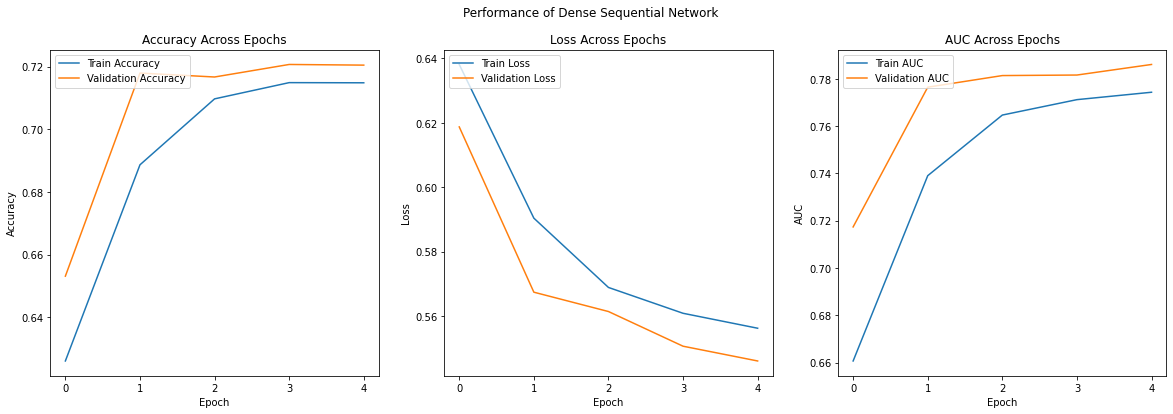

In [25]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot training and validation accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(0, 5, 1))
axes[0].set_title('Accuracy Across Epochs')
axes[0].legend(loc='upper left')

# Plot training and validation loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(0, 5, 1))
axes[1].set_title('Loss Across Epochs')
axes[1].legend(loc='upper left')

# Plot training and validation AUC
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Validation AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_xticks(np.arange(0, 5, 1))
axes[2].set_title('AUC Across Epochs')
axes[2].legend(loc='upper left')

# Set a main title for the figure
fig.suptitle('Performance of Dense Sequential Network')

# Display the plots
plt.show()


Though it appeared after the third epoch's completion that the model may have begun to overfit since the validation accuracy decreased and loss increased the fourth and fifth epoch indicated that there was still room for the neural network to improve in its predictive capacity.

Unfortunately, due to memory and time constraints I was unable to let this model run for more epochs to see how it performed; the training metrics appear to be reaching a point of diminishing returns so it would have been interesting to see hwo the validation metrics reacted.

While this model does a solid job, this architecture is only able to process raw pixels and is unable to interpret nearness of pixels to each other and larger structures so when we test a CNN next I am confident that it will outperform this model.

### 3.2 CNN Model (Max Pooling)
In the next phase of classification, we employ a Convolutional Neural Network (CNN), which is particularly well-suited for image classification tasks due to its outstanding performance in image processing. The architecture of this CNN includes several key components that work together to extract meaningful features from the images. First, the input image is processed by a convolutional layer with 32 filters of size 3x3, which reduces the spatial dimensions from 96x96x3 to 94x94x32. This is followed by a max pooling layer with a 2x2 filter, which downsamples the output from the previous layer, reducing the size to 47x47x32. Another convolutional layer, also with 32 filters of size 3x3, is applied, further reducing the spatial dimensions to 45x45x32, and is again followed by a max pooling layer that reduces the size to 22x22x32. A third convolutional layer with 16 filters of size 3x3 is applied, reducing the size to 20x20x16. 

After the convolutional and pooling layers, the model uses a flattening layer to reshape the output into a 1-dimensional vector with 6400 elements. This vector is then passed through a dense layer with 128 units, which helps in extracting and learning important features from the convolutional layers. Finally, the output is processed by another dense layer with a sigmoid activation function to produce a probability score, indicating whether the image depicts cancerous tissue or not. This architecture, with its combination of convolutional layers for feature extraction and dense layers for classification, is highly effective in identifying cancerous lesions in histopathological images.

In [26]:
# Initialize the CNN model
cnn_model = models.Sequential()

# Add the first convolutional layer with 32 filters of size 3x3 and ReLU activation
cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)))

# Add a max pooling layer with a pool size of 2x2
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Add a second convolutional layer with 32 filters of size 3x3 and ReLU activation
cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

# Add another max pooling layer with a pool size of 2x2
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Add a third convolutional layer with 16 filters of size 3x3 and ReLU activation
cnn_model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))

# Flatten the output from the convolutional layers to a 1D vector
cnn_model.add(layers.Flatten())

# Add a fully connected layer with 128 units and ReLU activation
cnn_model.add(layers.Dense(units=128, activation='relu'))

# Add an output layer with a sigmoid activation function for binary classification
cnn_model.add(layers.Dense(units=1, activation='sigmoid'))


The architecture (834,225) has 23.5% of the parameters compared to the architecture in Section 3.1 (3,549,953).

In [27]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        4624      
                                                                 
 flatten_1 (Flatten)         (None, 6400)             

In [ ]:
# Compile the CNN model with Adam optimizer, binary cross-entropy loss, and accuracy and AUC metrics
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')]
)

# Train the CNN model for 5 epochs, using the training generator and validation generator
history = cnn_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5
4814/4814 [==============================] - 1181s 245ms/step - loss: 0.4365 - accuracy: 0.7994 - auc: 0.8727 - val_loss: 0.3602 - val_accuracy: 0.8482 - val_auc: 0.9184
Epoch 2/5
4814/4814 [==============================] - 1191s 247ms/step - loss: 0.3394 - accuracy: 0.8546 - auc: 0.9253 - val_loss: 0.3071 - val_accuracy: 0.8725 - val_auc: 0.9443
Epoch 3/5
4814/4814 [==============================] - 953s 198ms/step - loss: 0.2977 - accuracy: 0.8759 - auc: 0.9426 - val_loss: 0.2799 - val_accuracy: 0.8866 - val_auc: 0.9514
Epoch 4/5
4814/4814 [==============================] - 1010s 210ms/step - loss: 0.2717 - accuracy: 0.8874 - auc: 0.9524 - val_loss: 0.2641 - val_accuracy: 0.8934 - val_auc: 0.9550
Epoch 5/5
4814/4814 [==============================] - 891s 185ms/step - loss: 0.2504 - accuracy: 0.8975 - auc: 0.9595 - val_loss: 0.2755 - val_accuracy: 0.8874 - val_auc: 0.9519


Visualizing Performance

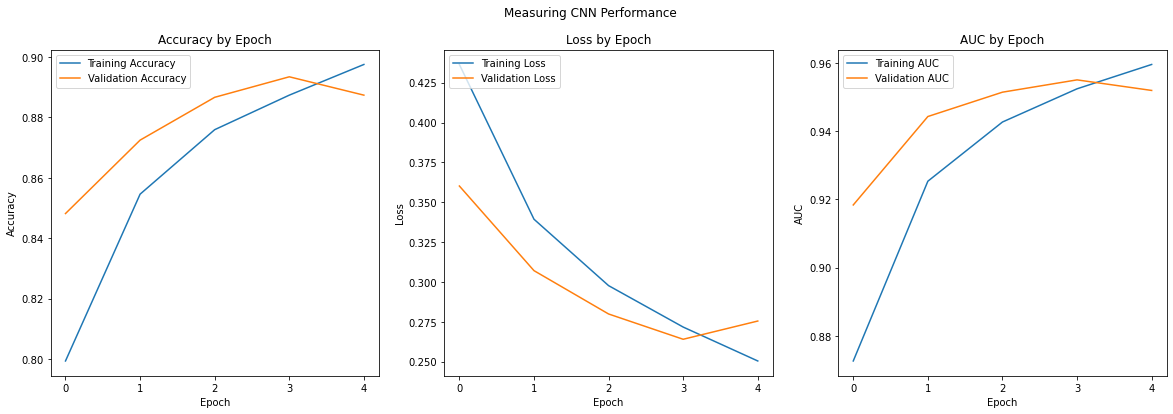

In [ ]:
# Create a figure and axes for plotting performance metrics
figure, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot Training and Validation Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(0, 5, 1))
axes[0].set_title('Accuracy Across Epochs')
axes[0].legend(loc='upper left')

# Plot Training and Validation Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(0, 5, 1))
axes[1].set_title('Loss Across Epochs')
axes[1].legend(loc='upper left')

# Plot Training and Validation AUC
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Validation AUC')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('AUC')
axes[2].set_xticks(np.arange(0, 5, 1))
axes[2].set_title('AUC Across Epochs')
axes[2].legend(loc='upper left')

# Set a general title for the figure
figure.suptitle('Evaluating CNN Model Performance')

# Display the figure
plt.show()

In this experiment, the CNN model demonstrated a significant performance improvement compared to the previously used Sequential Dense network. Specifically, the previous model reached a maximum accuracy of only 72%, while the new model's accuracy increased to approximately 89%. This improvement not only reflects the optimization of the model architecture but also indicates a more efficient feature learning capability. Additionally, the new CNN model significantly reduced the number of parameters, with the parameter count being only one-quarter of the previous model, which means we have substantially lowered computational complexity without sacrificing performance. This is particularly important for improving efficiency in real-world applications, especially when handling large-scale data, as reducing the model’s computational burden can speed up both training and inference.

More importantly, the new model's validation AUC (Area Under the Curve) reached 0.95 and plateaued during training. This metric indicates that the model has a strong ability to distinguish between cancerous and non-cancerous images, with almost no misclassifications. The high value and stability of AUC suggest that the model is effectively capturing key features in the images when handling such complex tasks, thereby significantly enhancing classification accuracy.

Compared to the previous model, the new CNN model has shown significant improvements across several performance metrics, including accuracy and AUC, indicating that the CNN architecture is better suited for this high-dimensional and complex dataset, enabling more efficient feature extraction and pattern recognition. At the same time, the reduction in parameters makes the model more lightweight and efficient, further enhancing its potential for real-world applications.

Nevertheless, further experimentation and fine-tuning still hold great potential, especially as the model's performance may improve with more training epochs. Therefore, with more computational resources and time, we expect to better optimize the model's generalization ability and further enhance its performance on unseen data. Building on the current strong foundation, we will continue exploring how to optimize the model by adjusting hyperparameters, increasing the training data, or improving the network structure, driving its application in real-world medical image processing.

### 3.3 CNN Model (Average pooling)

In this section, we replace the max pooling layers of the CNN (Max pooling) from Section 3.2 with average pooling layers.

In [ ]:
cnn_model_avg_pooling = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
cnn_model_avg_pooling.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 average_pooling2d (Average  (None, 47, 47, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 average_pooling2d_1 (Avera  (None, 22, 22, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 16)        4624      
                                                                 
 flatten_5 (Flatten)         (None, 6400)             

In [ ]:
cnn_model_avg_pooling.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')]
)

history_avg_pooling = cnn_model_avg_pooling.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5
4814/4814 [==============================] - 866s 180ms/step - loss: 0.4307 - accuracy: 0.8029 - auc: 0.8762 - val_loss: 0.4346 - val_accuracy: 0.8229 - val_auc: 0.9129
Epoch 2/5
4814/4814 [==============================] - 790s 164ms/step - loss: 0.3469 - accuracy: 0.8503 - auc: 0.9222 - val_loss: 0.3330 - val_accuracy: 0.8583 - val_auc: 0.9339
Epoch 3/5
4814/4814 [==============================] - 799s 166ms/step - loss: 0.3078 - accuracy: 0.8696 - auc: 0.9392 - val_loss: 0.2957 - val_accuracy: 0.8746 - val_auc: 0.9438
Epoch 4/5
4814/4814 [==============================] - 797s 166ms/step - loss: 0.2746 - accuracy: 0.8856 - auc: 0.9518 - val_loss: 0.3181 - val_accuracy: 0.8683 - val_auc: 0.9402
Epoch 5/5
4814/4814 [==============================] - 805s 167ms/step - loss: 0.2460 - accuracy: 0.8997 - auc: 0.9611 - val_loss: 0.2939 - val_accuracy: 0.8805 - val_auc: 0.9447


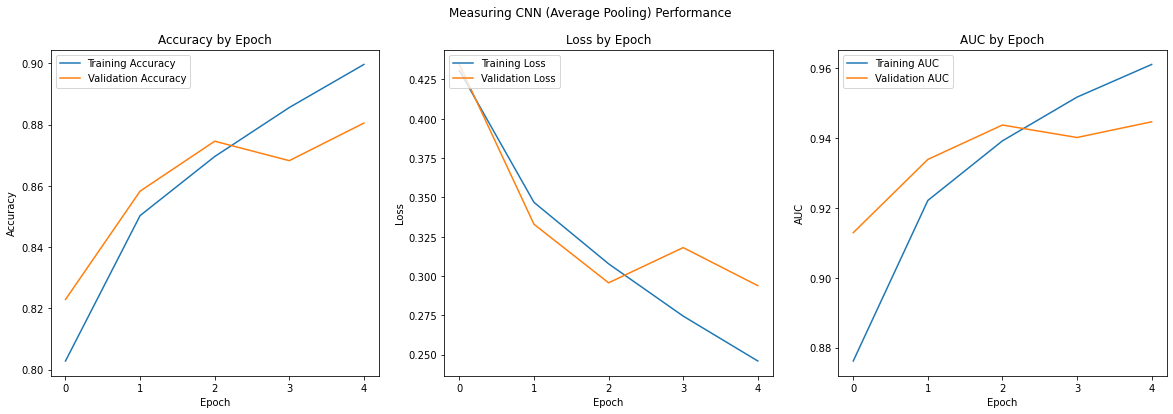

In [ ]:
# Create a figure with 3 subplots arranged in one row and three columns, with a specific figure size
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))  # Plot grid setup for accuracy, loss, and AUC

# Plotting Accuracy
# Plot the training and validation accuracy over the epochs
ax1.plot(history_avg_pooling.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
ax1.plot(history_avg_pooling.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy

# Labeling the x and y axes, and setting up ticks
ax1.set_xlabel('Epoch')  # Set the label for the x-axis (epochs)
ax1.set_ylabel('Accuracy')  # Set the label for the y-axis (accuracy)
ax1.set_xticks(np.arange(0, 5, 1))  # Set the x-axis tick values to represent the epoch range

# Set the title and legend for the accuracy subplot
ax1.set_title('Accuracy by Epoch')  # Title for the accuracy plot
ax1.legend(loc='upper left')  # Position the legend in the upper-left corner

# Plotting Loss
# Plot the training and validation loss over the epochs
ax2.plot(history_avg_pooling.history['loss'], label='Training Loss')  # Plot training loss
ax2.plot(history_avg_pooling.history['val_loss'], label='Validation Loss')  # Plot validation loss

# Labeling the x and y axes, and setting up ticks
ax2.set_xlabel('Epoch')  # Label for the x-axis (epochs)
ax2.set_ylabel('Loss')  # Label for the y-axis (loss)
ax2.set_xticks(np.arange(0, 5, 1))  # Set the x-axis ticks to represent the epoch range

# Set the title and legend for the loss subplot
ax2.set_title('Loss by Epoch')  # Title for the loss plot
ax2.legend(loc='upper left')  # Position the legend in the upper-left corner

# Plotting AUC (Area Under Curve)
# Plot the training and validation AUC over the epochs
ax3.plot(history_avg_pooling.history['auc'], label='Training AUC')  # Plot training AUC
ax3.plot(history_avg_pooling.history['val_auc'], label='Validation AUC')  # Plot validation AUC

# Labeling the x and y axes, and setting up ticks
ax3.set_xlabel('Epoch')  # Label for the x-axis (epochs)
ax3.set_ylabel('AUC')  # Label for the y-axis (AUC)
ax3.set_xticks(np.arange(0, 5, 1))  # Set the x-axis ticks to represent the epoch range

# Set the title and legend for the AUC subplot
ax3.set_title('AUC by Epoch')  # Title for the AUC plot
ax3.legend(loc='upper left')  # Position the legend in the upper-left corner

# Add a main title for the entire figure
fig.suptitle('Measuring CNN (Average Pooling) Performance')  # Main title for the entire figure

# Display the plot
plt.show()  # Show the figure with all subplots

The CNN with average pooling performs well in the experiment, similar to the previous variant with max pooling, effectively extracting image features. However, throughout the training process, the CNN with average pooling tends to slightly underperform compared to the max pooling version, particularly in terms of convergence speed and overall performance. While both models achieve high accuracy in the end, the max pooling CNN shows a stronger advantage in handling complex features, especially in capturing local and spatial information. Given this, although average pooling can reduce computational costs in certain cases, to further enhance the model's performance, we will continue to explore other hyperparameter tuning opportunities using max pooling.

### 3.4 CNN (Dropout Layers)

We added dropout layers after each max pooling layer in the CNN (Max pooling) method introduced in Section 3.2.

In [ ]:
# Initialize the model using the Sequential API
cnn_model_dropout = models.Sequential()

# First Convolutional Layer - 32 filters, 3x3 kernel, ReLU activation
cnn_model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))

# First Max Pooling Layer - 2x2 filter
cnn_model_dropout.add(layers.MaxPooling2D((2, 2)))

# Dropout Layer - Dropout rate of 40% to prevent overfitting
cnn_model_dropout.add(layers.Dropout(0.4))

# Second Convolutional Layer - 32 filters, 3x3 kernel, ReLU activation
cnn_model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Second Max Pooling Layer - 2x2 filter
cnn_model_dropout.add(layers.MaxPooling2D((2, 2)))

# Dropout Layer - Dropout rate of 40% again to prevent overfitting
cnn_model_dropout.add(layers.Dropout(0.4))

# Third Convolutional Layer - 16 filters, 3x3 kernel, ReLU activation
cnn_model_dropout.add(layers.Conv2D(16, (3, 3), activation='relu'))

# Flatten Layer - Converts the 2D output into a 1D vector
cnn_model_dropout.add(layers.Flatten())

# Fully Connected (Dense) Layer - 128 units, ReLU activation
cnn_model_dropout.add(layers.Dense(128, activation='relu'))

# Output Layer - 1 unit, Sigmoid activation for binary classification
cnn_model_dropout.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_model_dropout.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 32)      

In [ ]:
# Compile the model with Adam optimizer, binary cross-entropy loss, and track accuracy and AUC
cnn_model_dropout.compile(optimizer='adam',  # Using Adam optimizer for training
                          loss='binary_crossentropy',  # Binary cross-entropy loss function for binary classification
                          metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])  # Track accuracy and AUC

# Train the model on the training data for 5 epochs and validate using validation data
history_dropout = cnn_model_dropout.fit(train_generator,  # Training data generator
                                         epochs=5,  # Number of training epochs
                                         validation_data=validation_generator)  # Validation data generator

Epoch 1/5
4814/4814 [==============================] - 1054s 219ms/step - loss: 0.4462 - accuracy: 0.7948 - auc: 0.8669 - val_loss: 0.4700 - val_accuracy: 0.7758 - val_auc: 0.9114
Epoch 2/5
4814/4814 [==============================] - 874s 182ms/step - loss: 0.3613 - accuracy: 0.8434 - auc: 0.9151 - val_loss: 0.3980 - val_accuracy: 0.8259 - val_auc: 0.9292
Epoch 3/5
4814/4814 [==============================] - 880s 183ms/step - loss: 0.3292 - accuracy: 0.8599 - auc: 0.9299 - val_loss: 0.4038 - val_accuracy: 0.8285 - val_auc: 0.9184
Epoch 4/5
4814/4814 [==============================] - 896s 186ms/step - loss: 0.3135 - accuracy: 0.8675 - auc: 0.9368 - val_loss: 0.4053 - val_accuracy: 0.8270 - val_auc: 0.9260
Epoch 5/5
4814/4814 [==============================] - 927s 193ms/step - loss: 0.3025 - accuracy: 0.8732 - auc: 0.9411 - val_loss: 0.4044 - val_accuracy: 0.8439 - val_auc: 0.9364


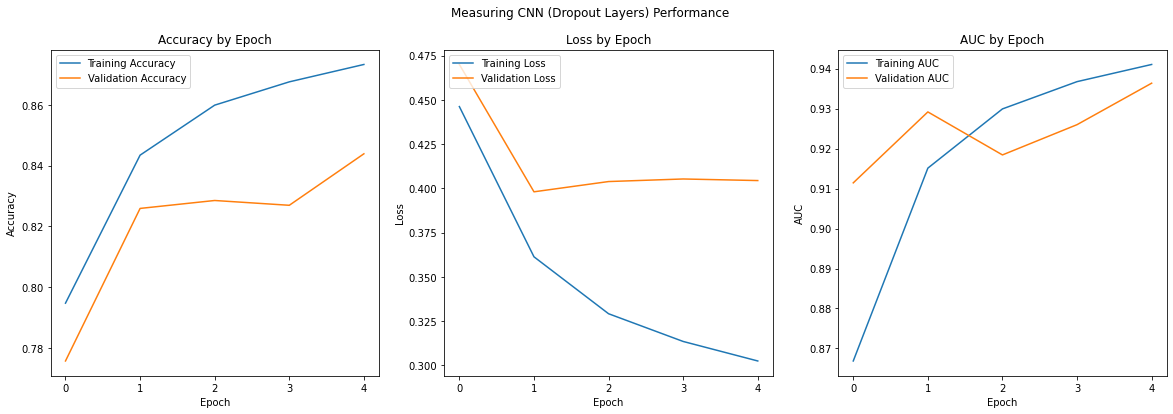

In [ ]:
# Create a figure with 3 subplots (one for accuracy, one for loss, and one for AUC)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))  # Set up the layout of the plots

# Plotting Accuracy
ax1.plot(history_dropout.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
ax1.plot(history_dropout.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
ax1.set_xlabel('Epoch')  # Label for the x-axis (Epochs)
ax1.set_ylabel('Accuracy')  # Label for the y-axis (Accuracy)
ax1.set_xticks(np.arange(0, 5, 1))  # Set x-axis ticks for epochs
ax1.set_title('Accuracy by Epoch')  # Title for the accuracy plot
ax1.legend(loc='upper left')  # Display legend in the upper left corner

# Plotting Loss
ax2.plot(history_dropout.history['loss'], label='Training Loss')  # Plot training loss
ax2.plot(history_dropout.history['val_loss'], label='Validation Loss')  # Plot validation loss
ax2.set_xlabel('Epoch')  # Label for the x-axis (Epochs)
ax2.set_ylabel('Loss')  # Label for the y-axis (Loss)
ax2.set_xticks(np.arange(0, 5, 1))  # Set x-axis ticks for epochs
ax2.set_title('Loss by Epoch')  # Title for the loss plot
ax2.legend(loc='upper left')  # Display legend in the upper left corner

# Plotting AUC
ax3.plot(history_dropout.history['auc'], label='Training AUC')  # Plot training AUC
ax3.plot(history_dropout.history['val_auc'], label='Validation AUC')  # Plot validation AUC
ax3.set_xlabel('Epoch')  # Label for the x-axis (Epochs)
ax3.set_ylabel('AUC')  # Label for the y-axis (AUC)
ax3.set_xticks(np.arange(0, 5, 1))  # Set x-axis ticks for epochs
ax3.set_title('AUC by Epoch')  # Title for the AUC plot
ax3.legend(loc='upper left')  # Display legend in the upper left corner

# Set a common title for all subplots
fig.suptitle('Measuring CNN (Dropout Layers) Performance')  # Title for the entire figure

# Show the plots
plt.show()  # Render and display the plots

The CNN with dropout layers effectively prevents overfitting, but it also somewhat weakens the model's ability to capture the true signal in the data. Although it performs reasonably well, its performance is measurably worse than the two prior CNNs that were trained on this data.

### 3.5 CNN (Regularization)

In [ ]:
# Define a Sequential model for CNN with batch normalization
cnn_model_normalization = models.Sequential()

# First convolutional layer: 32 filters, 3x3 kernel, ReLU activation, input shape (96x96x3)
cnn_model_normalization.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))

# First max pooling layer: 2x2 filter to reduce spatial dimensions
cnn_model_normalization.add(layers.MaxPooling2D((2, 2)))

# First batch normalization layer to normalize activations from the previous layer
cnn_model_normalization.add(layers.BatchNormalization())

# Second convolutional layer: 32 filters, 3x3 kernel, ReLU activation
cnn_model_normalization.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Second max pooling layer: 2x2 filter to reduce spatial dimensions
cnn_model_normalization.add(layers.MaxPooling2D((2, 2)))

# Second batch normalization layer to normalize activations from the previous layer
cnn_model_normalization.add(layers.BatchNormalization())

# Third convolutional layer: 16 filters, 3x3 kernel, ReLU activation
cnn_model_normalization.add(layers.Conv2D(16, (3, 3), activation='relu'))

# Flatten layer: Flatten the 3D tensor into 1D for the dense layer
cnn_model_normalization.add(layers.Flatten())

# Dense layer: 128 units, ReLU activation
cnn_model_normalization.add(layers.Dense(128, activation='relu'))

# Output layer: Single unit with sigmoid activation to classify as binary (cancerous or not)
cnn_model_normalization.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_model_normalization.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 47, 47, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                     

In [ ]:
# Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy & AUC metrics
cnn_model_normalization.compile(optimizer='adam',  # Optimizer for the model
                                loss='binary_crossentropy',  # Loss function for binary classification
                                metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])  # Metrics to track performance

# Train the model using the train_generator for training data, and validate on validation_generator
history_normalization = cnn_model_normalization.fit(
    train_generator,  # The training data generator
    epochs=5,  # The number of epochs for training
    validation_data=validation_generator  # The validation data generator
)

Epoch 1/5
4814/4814 [==============================] - 968s 201ms/step - loss: 0.3641 - accuracy: 0.8427 - auc: 0.9141 - val_loss: 0.3475 - val_accuracy: 0.8435 - val_auc: 0.9431
Epoch 2/5
4814/4814 [==============================] - 897s 186ms/step - loss: 0.2881 - accuracy: 0.8814 - auc: 0.9464 - val_loss: 0.2606 - val_accuracy: 0.8941 - val_auc: 0.9568
Epoch 3/5
4814/4814 [==============================] - 870s 181ms/step - loss: 0.2544 - accuracy: 0.8960 - auc: 0.9582 - val_loss: 0.2759 - val_accuracy: 0.8887 - val_auc: 0.9530
Epoch 4/5
4814/4814 [==============================] - 915s 190ms/step - loss: 0.2313 - accuracy: 0.9065 - auc: 0.9653 - val_loss: 0.3046 - val_accuracy: 0.8768 - val_auc: 0.9427
Epoch 5/5
4814/4814 [==============================] - 977s 203ms/step - loss: 0.2054 - accuracy: 0.9176 - auc: 0.9727 - val_loss: 0.3484 - val_accuracy: 0.8586 - val_auc: 0.9219


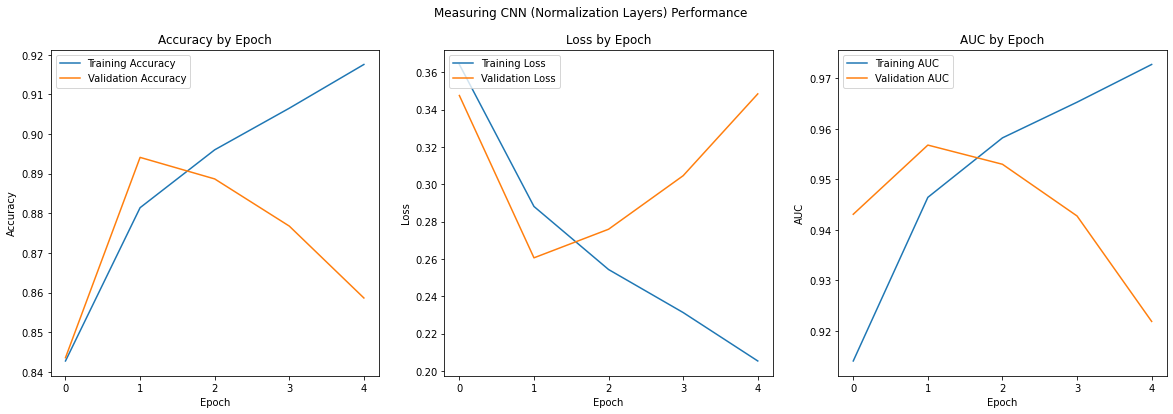

In [ ]:
# Create a figure with three subplots for Accuracy, Loss, and AUC
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot Accuracy over epochs
ax1.plot(history_normalization.history['accuracy'], label='Training Accuracy')  # Training accuracy
ax1.plot(history_normalization.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy
ax1.set_xlabel('Epoch')  # Label for the x-axis
ax1.set_ylabel('Accuracy')  # Label for the y-axis
ax1.set_xticks(np.arange(0, 5, 1))  # X-axis ticks for each epoch
ax1.set_title('Accuracy by Epoch')  # Title of the plot
ax1.legend(loc='upper left')  # Position of the legend

# Plot Loss over epochs
ax2.plot(history_normalization.history['loss'], label='Training Loss')  # Training loss
ax2.plot(history_normalization.history['val_loss'], label='Validation Loss')  # Validation loss
ax2.set_xlabel('Epoch')  # Label for the x-axis
ax2.set_ylabel('Loss')  # Label for the y-axis
ax2.set_xticks(np.arange(0, 5, 1))  # X-axis ticks for each epoch
ax2.set_title('Loss by Epoch')  # Title of the plot
ax2.legend(loc='upper left')  # Position of the legend

# Plot AUC over epochs
ax3.plot(history_normalization.history['auc'], label='Training AUC')  # Training AUC
ax3.plot(history_normalization.history['val_auc'], label='Validation AUC')  # Validation AUC
ax3.set_xlabel('Epoch')  # Label for the x-axis
ax3.set_ylabel('AUC')  # Label for the y-axis
ax3.set_xticks(np.arange(0, 5, 1))  # X-axis ticks for each epoch
ax3.set_title('AUC by Epoch')  # Title of the plot
ax3.legend(loc='upper left')  # Position of the legend

# Set a general title for the entire figure
fig.suptitle('Measuring CNN (Normalization Layers) Performance')

# Display the figure
plt.show()

Incorporating normalization layers into the CNN led to strong initial performance, with the accuracy, loss, and AUC closely matching the best results from previous models tested. However, by the second epoch, signs of overfitting become evident, as the validation metrics start to decline over the next three epochs while the training metrics continue to improve.

### 3.6 CNN (Nadam Optimizer)
Similar to the previous CNN model iterations, we will make adjustments to a part of the model. This time, we are replacing the 'adam' optimizer with the 'nadam' optimizer to investigate whether utilizing Nesterov momentum enhances our model’s performance.

In [ ]:
from tensorflow.keras import models, layers

# Define CNN model with 'nadam' optimizer
cnn_model_nadam = models.Sequential([
    # First convolutional layer followed by max pooling
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional layer followed by max pooling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional layer
    layers.Conv2D(16, (3, 3), activation='relu'),
    
    # Flattening the output to connect to dense layers
    layers.Flatten(),
    
    # Fully connected dense layer
    layers.Dense(128, activation='relu'),
    
    # Output layer with sigmoid activation
    layers.Dense(1, activation='sigmoid')
])

# Model summary to inspect the architecture
cnn_model_nadam.summary()

In [ ]:
cnn_model_nadam.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 20, 20, 16)        4624      
                                                                 
 flatten_12 (Flatten)        (None, 6400)            

In [ ]:
import tensorflow as tf

# Compile the CNN model with Nadam optimizer
cnn_model_nadam.compile(
    optimizer='nadam',                     # Using Nadam optimizer
    loss='binary_crossentropy',            # Binary crossentropy loss for binary classification
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Metrics: accuracy and AUC
)

# Train the model
history_nadam = cnn_model_nadam.fit(
    train_generator,                       # Training data generator
    epochs=5,                              # Number of epochs
    validation_data=validation_generator   # Validation data generator
)

Epoch 1/5
4814/4814 [==============================] - 862s 179ms/step - loss: 0.4204 - accuracy: 0.8052 - auc: 0.8821 - val_loss: 0.4011 - val_accuracy: 0.8265 - val_auc: 0.9267
Epoch 2/5
4814/4814 [==============================] - 824s 171ms/step - loss: 0.3171 - accuracy: 0.8665 - auc: 0.9345 - val_loss: 0.2880 - val_accuracy: 0.8803 - val_auc: 0.9462
Epoch 3/5
4814/4814 [==============================] - 857s 178ms/step - loss: 0.2840 - accuracy: 0.8823 - auc: 0.9475 - val_loss: 0.2736 - val_accuracy: 0.8891 - val_auc: 0.9517
Epoch 4/5
4814/4814 [==============================] - 963s 200ms/step - loss: 0.2612 - accuracy: 0.8931 - auc: 0.9557 - val_loss: 0.3006 - val_accuracy: 0.8768 - val_auc: 0.9451
Epoch 5/5
4814/4814 [==============================] - 1132s 235ms/step - loss: 0.2371 - accuracy: 0.9033 - auc: 0.9634 - val_loss: 0.2710 - val_accuracy: 0.8923 - val_auc: 0.9534


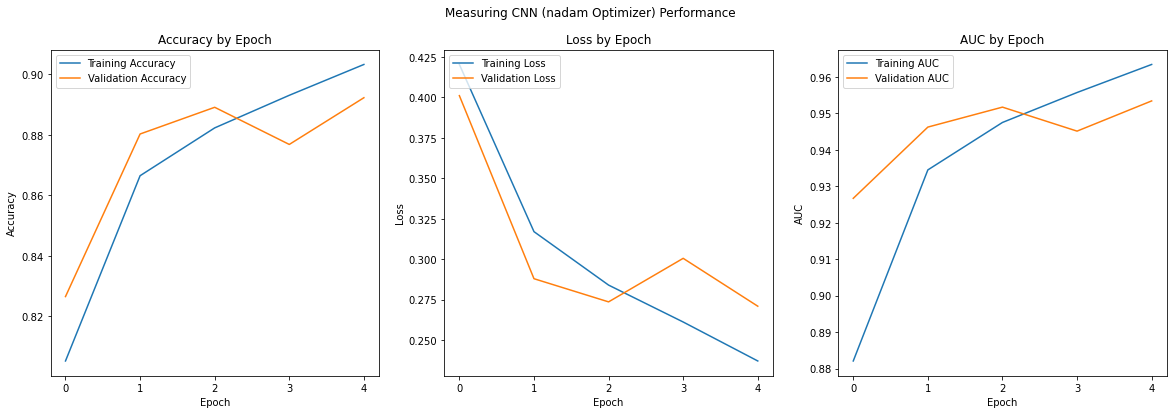

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Define a helper function for plotting
def plot_metric(ax, metric_name, metric_values, val_metric_values, title, xlabel, ylabel):
    ax.plot(metric_values, label=f'Training {metric_name}')
    ax.plot(val_metric_values, label=f'Validation {metric_name}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(0, len(metric_values), 1))
    ax.set_title(title)
    ax.legend(loc='upper left')

# Accuracy plot
plot_metric(axes[0], 'Accuracy', history_nadam.history['accuracy'], history_nadam.history['val_accuracy'], 'Accuracy by Epoch', 'Epoch', 'Accuracy')

# Loss plot
plot_metric(axes[1], 'Loss', history_nadam.history['loss'], history_nadam.history['val_loss'], 'Loss by Epoch', 'Epoch', 'Loss')

# AUC plot
plot_metric(axes[2], 'AUC', history_nadam.history['auc'], history_nadam.history['val_auc'], 'AUC by Epoch', 'Epoch', 'AUC')

# Set the main title and display the plot
fig.suptitle('Measuring CNN (Nadam Optimizer) Performance')
plt.show()

The performance of the CNN with the 'nadam' optimizer closely mirrors that of the 'adam' optimizer, which is expected given that 'nadam' is essentially an extension of 'adam'. However, due to limitations in memory and time, I was unable to run additional epochs. It would have been insightful to observe whether the validation metrics continued to improve, potentially leading to a better model fit over more training iterations.

## 4. Conclusion

#### Base CNN Model

We initially constructed a simple CNN model, using standard convolutional layers and max-pooling layers to extract features. This model served as a foundation for subsequent adjustments and performed relatively well on the given image classification task. However, it lacked mechanisms to control overfitting and was unable to capture larger structures in the input data effectively.

#### Adding Dropout Layers

To prevent overfitting, we added dropout layers after the max-pooling layers in the CNN. Dropout reduces the model's reliance on the training data by randomly dropping a portion of the neurons, improving the model's generalization ability. After adding dropout, the model performed well on the training set but showed a slight performance decline compared to the CNN without dropout. This suggests that while dropout helps mitigate overfitting, it may also suppress the model's ability to capture certain important signals in the data.

#### Introducing Batch Normalization Layers

To improve training speed and stabilize the model, we introduced batch normalization layers into the CNN. Batch normalization standardizes the inputs to each layer, reducing internal covariate shift, thus accelerating the training process and enhancing final test performance. The results showed that with batch normalization, the model performed very well in the early stages of training, with accuracy, loss, and AUC metrics nearly matching the best of all models tested. However, as training progressed, the model began to overfit, as evidenced by a degradation in validation performance over the next few epochs.

#### Using Nadam Optimizer

In terms of the optimizer, we replaced the traditional 'Adam' optimizer with the 'Nadam' optimizer. Nadam is based on Adam but introduces Nesterov momentum to improve the gradient update process. The experiment showed that the performance of the Nadam optimizer was very similar to that of Adam, indicating that Nadam did not bring significant improvement for this specific task. Due to resource constraints, we were unable to run more epochs, so we could not determine if the Nadam optimizer would yield better results after longer training.

#### Overall Performance and Conclusion

Through this experiment, we found that different optimization methods had varying impacts on the model's performance. Dropout significantly helped prevent overfitting but could negatively affect the model's expressive power, especially with limited training data or complex data distributions. Batch normalization effectively improved training stability and accelerated convergence but led to overfitting after extended training, especially without additional regularization techniques. The Nadam optimizer showed similar performance to Adam, with no substantial improvement observed in this task. The final results suggest that by combining these techniques appropriately, CNN model performance can be significantly improved. However, longer training and more fine-tuned adjustments are still necessary to enhance generalization and model accuracy while preventing overfitting.

## 5. Reference

[1] https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview<br>
[2] https://github.com/basveeling/pcam<br>
[3] https://github.com/cadenzonnefeld/HistopathologicCancerDetection<br>
[4] https://github.com/Michaels72/HistopathologicCancerDetection<br>
[5] https://github.com/MUmairAB/Breast-Cancer-Detection-using-CNNs-in-TensorFlow<br>
[6] https://github.com/OklenCodes/HistopathologicalCancerDetection<br>
[7] https://github.com/gsarti/cancer-detection<br>
[8] https://github.com/ZhangXX54/DDTNet